In [1]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns             #visualisation
import matplotlib.pyplot as plt   #visualisation
import os

%matplotlib inline 
sns.set(color_codes=True)

from dotenv import load_dotenv
from core_ds4a_project import cleaning, columns as project_columns, datasets

%load_ext autoreload
%autoreload 1
%aimport core_ds4a_project, core_ds4a_project.cleaning, core_ds4a_project.columns, core_ds4a_project.datasets

pd.set_option("display.max_columns", None)

In [4]:
import folium
import pingouin as pg
from folium.plugins import HeatMap

In [3]:
import statsmodels.formula.api as sm

Environment variables:

In [4]:
load_dotenv('envvars')

ROOT_DATA_PATH = os.environ.get('ROOT_DATA_PATH')
RAW_DATA_PATH = os.environ.get('RAW_DATA_PATH') or f'{ROOT_DATA_PATH}/raw'

Reading data:

In [5]:
(cartera_df, clientes_df, colocacion_df) = datasets.read_joining_datasets(dir_path=RAW_DATA_PATH)

Sorting CARTERA:

In [6]:
cartera_df = cartera_df.sort_values(['FECHA_CIERRE', 'OBLIGACION'], ascending=True)
ind_first = ~(cartera_df.duplicated(keep='first', subset='OBLIGACION'))
ind_last = ~(cartera_df.duplicated(keep='last', subset='OBLIGACION'))

<H2>Data for Modeling:</H2>

Lasts records by client:

In [7]:
lasts_records_cartera_df = cartera_df[ind_last].copy()
lasts_records_cartera_df.shape

(38641, 32)

In [8]:
lasts_records_cartera_df.head(5)

OBLIGACION  CLIENTE  TIPO_CLIENTE_COD     TIPO_CLIENTE  \
210924   171000008  FA12448               1.0  Microfinanciero   
210739   172000006  FA25175               1.0  Microfinanciero   
210815   173000013  FA23399               1.0  Microfinanciero   
210887   176000015  FA19928               1.0  Microfinanciero   
210843   177000008    FA227               1.0  Microfinanciero   

                      REGION MUNICIPIO_CLIENTE VALOR_CUOTA  CUOTAS_PACTADAS  \
210924            REGION SUR       SABANALARGA      197638               12   
210739  REGION VILLAVICENCIO     VILLAVICENCIO      293974               36   
210815           REGION META           ACACIAS      183032               24   
210887           REGION META           GRANADA      179930               24   
210843            REGION SUR         MONTERREY      103305               12   

        CUOTAS_PENDIENTES  TASA_PERIODICA PERIODICIDAD_PAGO  \
210924                 12            2.64           Mensual   
210739                 36            2.94           Mensual   
210815                 24            2.94           Mensual   
210887                 24            2.94           Mensual   
210843                 12            2.94           Mensual   

       CALIFICACION_CIERRE                             MODALIDAD    SALDO  \
210924                   A    CREDITO RURAL INDIVIDUAL - GERMINA  2000000   
210739                   A  DESARROLLO EMPRESARIAL CRECER (PYME)  6000000   
210815                   A  DESARROLLO EMPRESARIAL CRECER (PYME)  2950000   
210887                   A  DESARROLLO EMPRESARIAL CRECER (PYME)  2900000   
210843                   A  DESARROLLO EMPRESARIAL CRECER (PYME)  1000000   

       VENCIDA  DIAS_VENCIDO CAPITAL_VEN INTERES_VEN   MORA SEGURO_VIDA  \
210924    -                0        -           -      -           -      
210739    -                0        -           -      -           -      
210815    -                0        -           -      -           -      
210887    -                0        -           -      -           -      
210843    -                0        -           -      -           -      

       COMISION OTROS FECHA_ULT_PAGO FECHA_PROXIMO_PAGO  \
210924        0     0     2017-01-20         2017-02-19   
210739        0     0            NaT         2017-02-19   
210815        0     0            NaT         2017-02-27   
210887        0     0            NaT         2017-02-28   
210843        0     0            NaT         2017-02-28   

       FECHA_VENCIMIENTO_FINAL  PORCENTAJE_PAGO TIPO_CREDITO SUCURSAL_COD  \
210924              2018-01-19            100.0        NUEVO          NaN   
210739              2020-01-19            100.0  RETANQUEADO          NaN   
210815              2019-01-27            100.0        NUEVO          NaN   
210887              2019-01-31            100.0        NUEVO          NaN   
210843              2018-01-31            100.0        NUEVO          NaN   

       FECHA_CIERRE  SUCURSAL_REAL  MUNICIPIO_LAT  MUNICIPIO_LON  
210924   2017-01-31      MONTERREY        4.85430      -73.04003  
210739   2017-01-31  VILLAVICENCIO        4.14200      -73.62664  
210815   2017-01-31        ACACIAS        3.98695      -73.75797  
210887   2017-01-31        GRANADA        3.54625      -73.70687  
210843   2017-01-31      MONTERREY        4.87802      -72.89575

Creditos y Clientes con calificacion 'A'

In [9]:
idx = lasts_records_cartera_df['CALIFICACION_CIERRE'] == 'A'
len(lasts_records_cartera_df[idx]), len(lasts_records_cartera_df[idx]['CLIENTE'].unique())

(33021, 19070)

Creditos y Clientes con calificacion diferente de 'A'

In [10]:
idx = lasts_records_cartera_df['CALIFICACION_CIERRE'] != 'A'
len(lasts_records_cartera_df[idx]), len(lasts_records_cartera_df[idx]['CLIENTE'].unique())

(5620, 5487)

In [11]:
model1_df = pd.merge(lasts_records_cartera_df, colocacion_df, how='left', on="OBLIGACION", suffixes=('_left', '_right'))
model1_df.shape

(38641, 57)

In [12]:
model1_df = model1_df.rename(columns={'CLIENTE_left':'CLIENTE',
                                      'VALOR_CUOTA_left':'VALOR_CUOTA'
                                     })

In [13]:
model_df = pd.merge(model1_df, clientes_df, how='left', on="CLIENTE", suffixes=('_left_model', '_right_client'))
model_df.shape

(38641, 83)

In [14]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38641 entries, 0 to 38640
Data columns (total 83 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OBLIGACION               38641 non-null  int32         
 1   CLIENTE                  38641 non-null  object        
 2   TIPO_CLIENTE_COD         38641 non-null  float64       
 3   TIPO_CLIENTE             38641 non-null  object        
 4   REGION                   38641 non-null  object        
 5   MUNICIPIO_CLIENTE        38641 non-null  object        
 6   VALOR_CUOTA              38641 non-null  object        
 7   CUOTAS_PACTADAS          38641 non-null  int32         
 8   CUOTAS_PENDIENTES        38641 non-null  int32         
 9   TASA_PERIODICA           38641 non-null  float64       
 10  PERIODICIDAD_PAGO_left   38641 non-null  category      
 11  CALIFICACION_CIERRE      38641 non-null  object        
 12  MODALIDAD_left           38641 n

In [15]:
null_eda = model_df.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

index  Nulos
22           FECHA_ULT_PAGO   3034
27             SUCURSAL_COD      8
29            SUCURSAL_REAL     12
30            MUNICIPIO_LAT     88
31            MUNICIPIO_LON     88
43            OBSERVACIONES    644
53        CREDITOS_VIGENTES  19887
56                  DEFAULT  37678
58                  ESTRATO     54
59                 SUCURSAL      1
62      ACTIVIDAD_ECONOMICA    251
64                   OFICIO   4024
66     RESPONSABLE_DE_HOGAR    490
67                OCUPACION    224
68  ACTIVIDAD_CIIU_PRIMARIA  18979
69         ESTADO_CIVIL_COD     98
71       NIVEL_ESTUDIOS_COD     12
72            PROFESION_COD  12723
74        TIPO_VIVIENDA_COD    116
75                PROFESION  23107
76           TIPO_UBICACION    161
77         FECHA_NACIMIENTO     31
78                   GENERO     31
79           NIVEL_ESTUDIOS    503
80             ESTADO_CIVIL    876
81            TIPO_VIVIENDA   1460

<H2>Feature Engineer</H2>

In [16]:
model_df['DEFAULT'].unique()

array([nan, True], dtype=object)

In [17]:
idx = model_df["DEFAULT"] != True
model_df.loc[idx,'DEFAULT'] = 0

In [18]:
idx = model_df["DEFAULT"] == True
model_df.loc[idx,'DEFAULT'] = 1

In [19]:
model_df['DEFAULT'] = model_df['DEFAULT'].astype('int64')

In [20]:
model_df['DEFAULT'].unique()

array([0, 1], dtype=int64)

- Mes(n-3) Credit 1 Q=A
- Mes(n-2) Credit 1 Q=A
- Mes(n-1) Credit 1 Q=B  ---- ultimo  -> DEFAULT_Q = 1

- Mes(n-1) Credito 2 Q=A ---- ultimo  -> DEFAULT_Q = 0

model_df['DEFAULT_Q'] = 0
nok = model_df["CALIFICACION_CIERRE"] != "A"
model_df.loc[nok,'DEFAULT_Q'] = 1

model_df.loc[nok,'DEFAULT_Q']

In [21]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38641 entries, 0 to 38640
Data columns (total 83 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OBLIGACION               38641 non-null  int32         
 1   CLIENTE                  38641 non-null  object        
 2   TIPO_CLIENTE_COD         38641 non-null  float64       
 3   TIPO_CLIENTE             38641 non-null  object        
 4   REGION                   38641 non-null  object        
 5   MUNICIPIO_CLIENTE        38641 non-null  object        
 6   VALOR_CUOTA              38641 non-null  object        
 7   CUOTAS_PACTADAS          38641 non-null  int32         
 8   CUOTAS_PENDIENTES        38641 non-null  int32         
 9   TASA_PERIODICA           38641 non-null  float64       
 10  PERIODICIDAD_PAGO_left   38641 non-null  category      
 11  CALIFICACION_CIERRE      38641 non-null  object        
 12  MODALIDAD_left           38641 n

In [22]:
null_eda = model_df.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

index  Nulos
22           FECHA_ULT_PAGO   3034
27             SUCURSAL_COD      8
29            SUCURSAL_REAL     12
30            MUNICIPIO_LAT     88
31            MUNICIPIO_LON     88
43            OBSERVACIONES    644
53        CREDITOS_VIGENTES  19887
58                  ESTRATO     54
59                 SUCURSAL      1
62      ACTIVIDAD_ECONOMICA    251
64                   OFICIO   4024
66     RESPONSABLE_DE_HOGAR    490
67                OCUPACION    224
68  ACTIVIDAD_CIIU_PRIMARIA  18979
69         ESTADO_CIVIL_COD     98
71       NIVEL_ESTUDIOS_COD     12
72            PROFESION_COD  12723
74        TIPO_VIVIENDA_COD    116
75                PROFESION  23107
76           TIPO_UBICACION    161
77         FECHA_NACIMIENTO     31
78                   GENERO     31
79           NIVEL_ESTUDIOS    503
80             ESTADO_CIVIL    876
81            TIPO_VIVIENDA   1460

len(model_df.loc[model_df['DEFAULT_Q'] == 1])

len(model_df.loc[model_df['DEFAULT_Q'] == 0])

In [23]:
len(model_df.loc[model_df['DEFAULT'] == 1])

963

In [24]:
len(model_df.loc[model_df['DEFAULT'] == 0])

37678

Looking at correlations:

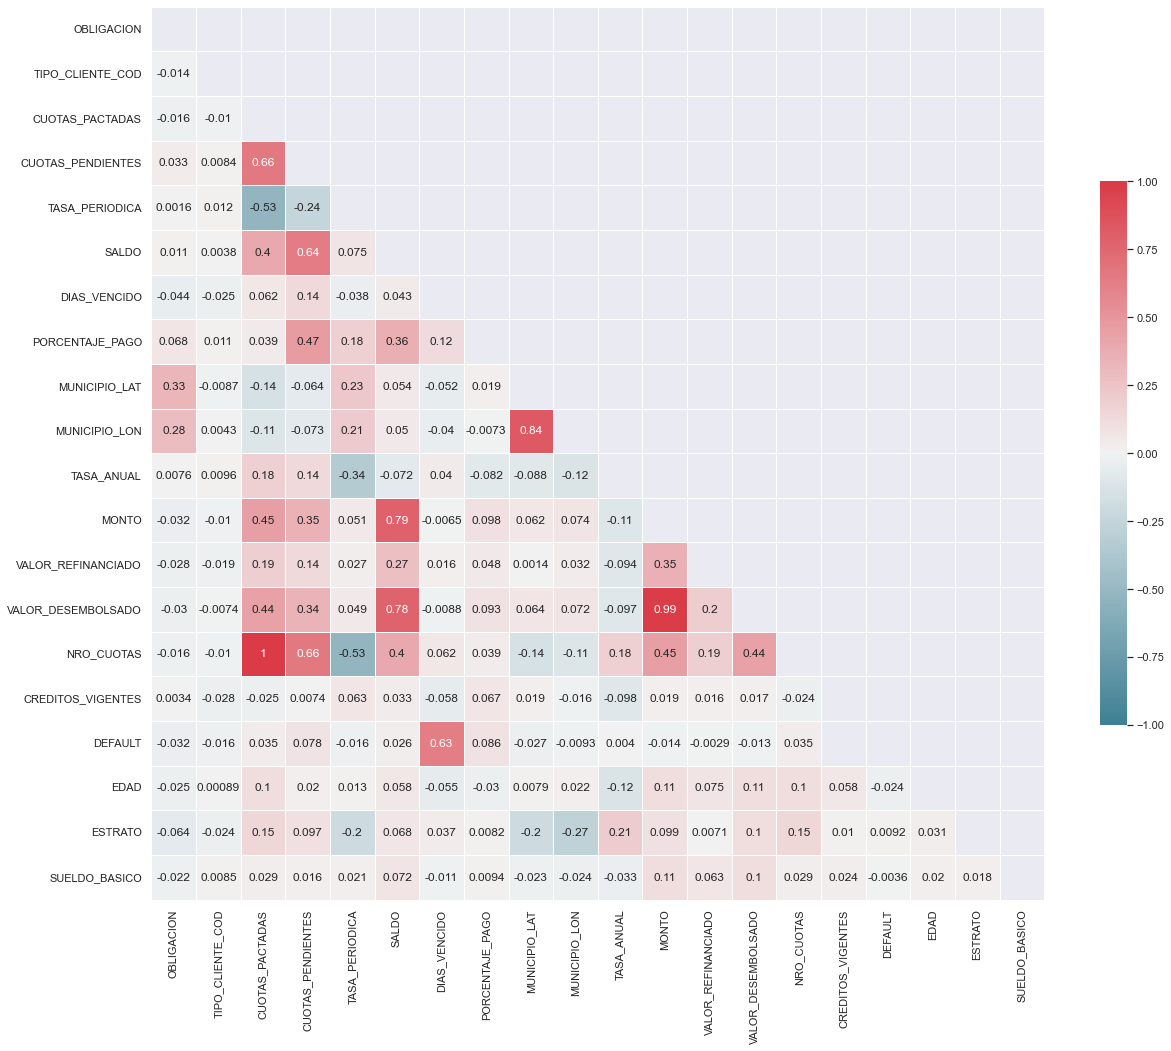

In [25]:
#compute correlation matrix
df_correlations = model_df.corr()

#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,
            mask=mask,  
            vmax=1, 
            vmin=-1, 
            cmap=cmap, 
            center=0,
            annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Split our data into training and testing sets (an 80-20 split is a good starting point):

In [26]:
np.random.seed(1234) # a seed makes the analysis reproducible
                     # so everyone will get the same results

n_data = len(model_df)

# Randomly choose 0.8n indices between 1 and n
idx_train = np.random.choice(range(n_data), int(0.8*n_data), replace=False)

# The test set is comprised from all the indices that were
# not selected in the training set:
idx_test  = np.asarray(list(set(range(n_data)) - set(idx_train)))

df_train     = model_df.iloc[idx_train] # the training data set
df_test      = model_df.iloc[idx_test]  # the test data set

print(df_train.shape) 
print(df_test.shape)  

(30912, 83)
(7729, 83)


len(df_train.loc[df_train['DEFAULT_Q'] == 1])

len(df_test.loc[df_test['DEFAULT_Q'] == 1])

In [27]:
len(df_train.loc[df_train['DEFAULT'] == 1])

780

In [28]:
len(df_train.loc[df_train['DEFAULT'] == 0])

30132

In [29]:
df_train.shape

(30912, 83)

In [30]:
df_train.dropna().shape

(3382, 83)

<H2> MODEL 2: Logistic Regression </H2>

Classification model for predicting if a client is going to be in default as a binary or binomial classification:

See: https://realpython.com/logistic-regression-python/

Week 7 - case.cross_validation_fellow

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [32]:
def fit_logistic_regression(X,y):
    """
    fit a logistic regression with feature matrix X and binary output y
    """
    # Create model and fit (or train) model
    clf = LogisticRegression(solver='saga',                             
                             tol=10**-4,
                             max_iter = 4000,
                             fit_intercept=True,
                             multi_class='multinomial'
                            ).fit(X,y)
    return clf

In [33]:
# we will use a 70%/30% split for training/validation
n_total = len(model_df)
n_train = int(0.7*n_total)

X, y = model_df[['EDAD']], model_df.DEFAULT
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

In [34]:
model_reg = fit_logistic_regression(X_train, y_train)  # fit a logistic regression

Check model's performance with .predict_proba(), which returns the matrix of probabilities that the predicted output is equal to zero or one:

In [35]:
y_test_pred = model_reg.predict_proba(X_test)[:,1]     # make probabilistic predictions on test set
y_test_pred

array([0.03991789, 0.04047193, 0.0427626 , ..., 0.03334638, 0.04517681,
       0.0427626 ])

ROC curve of model_reg and find the area under the curve:

C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


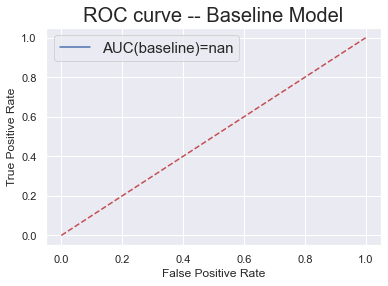

In [36]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)  #compute FPR/TPR
auc_baseline = auc(fpr, tpr) # compute AUC

plt.plot(fpr, tpr, "b-", label="AUC(baseline)={:2.2f}".format(auc_baseline))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("ROC curve -- Baseline Model", fontsize=20);

The attribute .classes_ represents the array of distinct values that y takes:

In [37]:
model_reg.classes_

array([0, 1], dtype=int64)

Get the value of the slope 𝑏₁ and the intercept 𝑏₀ of the linear function 𝑓 like so:

In [38]:
model_reg.intercept_

array([-1.32441286])

In [39]:
model_reg.coef_

array([[-0.00718065]])

In [40]:
model_reg.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [41]:
model_reg.score(X, y)

0.9750782847234802

We can get information on the accuracy of the model with a confusion matrix. In the case of binary classification, the confusion matrix shows the numbers of the following:

- True negatives in the upper-left position
- False negatives in the lower-left position
- False positives in the upper-right position
- True positives in the lower-right position

In [42]:
confusion_matrix(y, model_reg.predict(X))

array([[37678,     0],
       [  963,     0]], dtype=int64)

The obtained matrix shows the following:

37678 true negative predictions: The first 37678 observations are zeros predicted correctly.
963 false negative predictions: These are the ones wrongly predicted as zeros.
0 false positive prediction: The 0 observation is a zero that was wrongly predicted as one.
0 true positive predictions: The last 0 observations are ones predicted correctly.

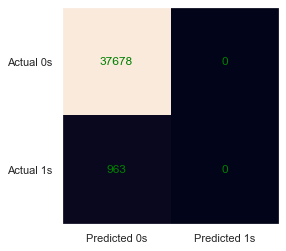

In [43]:
cm = confusion_matrix(y, model_reg.predict(X))

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='Green')
plt.show()

In [44]:
print(classification_report(y, model_reg.predict(X)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     37678
           1       0.00      0.00      0.00       963

    accuracy                           0.98     38641
   macro avg       0.49      0.50      0.49     38641
weighted avg       0.95      0.98      0.96     38641



C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cross-validation

skf = StratifiedKFold(n_splits=10)
for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
    plt.plot(train_index, [k+1 for _ in train_index], ".")
plt.ylim(0,12)
plt.ylabel("FOLD")
plt.title("CROSS VALIDATION FOLDS")

In [45]:
def fit_logistic_regression(X, y):
    """
    fit a logistic regression with feature matrix X and binary output y
    """
    # Create model and fit (or train) model
    clf = LogisticRegression(solver='saga',                             
                             tol=10**-4,
                             max_iter = 4000,
                             fit_intercept=True,
                             multi_class='multinomial'
                            ).fit(X,y)
    return clf

In [46]:
def compute_AUC(X, y, train_index, test_index):
    """
    feature/output: X, y
    dataset split: train_index, test_index
    """
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf = fit_logistic_regression(X_train, y_train)
    default_proba_test = clf.predict_proba(X_test)[:,1]  
    fpr, tpr, _ = roc_curve(y_test, default_proba_test)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr

In [47]:
def cross_validation_AUC(X,y, nfold=10):
    """
    use a n-fold cross-validation for computing AUC estimates
    """
    skf = StratifiedKFold(n_splits=nfold)  #create a cross-validation splitting
    auc_list = [] #this list will contain the AUC estimates associated with each fold
    for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
        auc_score, _, _ = compute_AUC(X, y, train_index, test_index)
        auc_list.append(auc_score)
    return auc_list

We will now estimate and compare, through cross-validation analysis, the performance of all the "simple models" that only use one numerical feature as input. We will use the logarithmic transform for the loan_amount variable:

In [48]:
# let us extract only the numerical (i.e non-categorical) features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Data_numerics = model_df.select_dtypes(include=numerics)
Data_numerics = Data_numerics.drop(["OBLIGACION", "TIPO_CLIENTE_COD", 
                                    "CUOTAS_PENDIENTES", "DIAS_VENCIDO", 
                                    "PORCENTAJE_PAGO", "VALOR_REFINANCIADO",
                                    "VALOR_DESEMBOLSADO", "NRO_CUOTAS",
                                    "SALDO", "CREDITOS_VIGENTES"
                                   ], axis=1)
Data_numerics

CUOTAS_PACTADAS  TASA_PERIODICA  MUNICIPIO_LAT  MUNICIPIO_LON  \
0                   12            2.64        4.85430      -73.04003   
1                   36            2.94        4.14200      -73.62664   
2                   24            2.94        3.98695      -73.75797   
3                   24            2.94        3.54625      -73.70687   
4                   12            2.94        4.87802      -72.89575   
...                ...             ...            ...            ...   
38636                1            9.08        6.46065      -71.73618   
38637               24            3.20        6.46065      -71.73618   
38638                1            9.08        6.46065      -71.73618   
38639                6            8.13        6.46065      -71.73618   
38640               18            3.30        6.46065      -71.73618   

       TASA_ANUAL    MONTO  DEFAULT  EDAD  ESTRATO  SUELDO_BASICO  
0           31.67  2000000        0    51      1.0            0.0  
1           35.29  6000000        0    48      2.0            0.0  
2           35.29  2950000        0    53      2.0            0.0  
3           35.29  2900000        0    50      2.0      1400000.0  
4           35.29  1000000        0    73      1.0            0.0  
...           ...      ...      ...   ...      ...            ...  
38636       35.28  1000000        0    54      1.0            0.0  
38637       38.40  6000000        0    34      1.0            0.0  
38638       35.28  1000000        0    50      1.0      3000000.0  
38639       31.68  4000000        0    28      1.0            0.0  
38640       39.60  2000000        0    32      1.0            0.0  

[38641 rows x 10 columns]

In [49]:
Data_numerics.shape

(38641, 10)

In [50]:
Data_numerics = Data_numerics.dropna()
null_eda = Data_numerics.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

Empty DataFrame
Columns: [index, Nulos]
Index: []

In [51]:
# Using a log scale when appropriate
#Data_numerics["SUELDO_BASICO"] = np.log10(Data_numerics["SUELDO_BASICO"])
Data_numerics["MONTO"] = np.log10(Data_numerics["MONTO"])
#Data_numerics["avg_cur_bal"] = np.log10(1.+Data_numerics["avg_cur_bal"])
Data_numerics

C:\Users\mchah\AppData\Local\Temp\ipykernel_4020\3039772640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_numerics["MONTO"] = np.log10(Data_numerics["MONTO"])


CUOTAS_PACTADAS  TASA_PERIODICA  MUNICIPIO_LAT  MUNICIPIO_LON  \
0                   12            2.64        4.85430      -73.04003   
1                   36            2.94        4.14200      -73.62664   
2                   24            2.94        3.98695      -73.75797   
3                   24            2.94        3.54625      -73.70687   
4                   12            2.94        4.87802      -72.89575   
...                ...             ...            ...            ...   
38636                1            9.08        6.46065      -71.73618   
38637               24            3.20        6.46065      -71.73618   
38638                1            9.08        6.46065      -71.73618   
38639                6            8.13        6.46065      -71.73618   
38640               18            3.30        6.46065      -71.73618   

       TASA_ANUAL     MONTO  DEFAULT  EDAD  ESTRATO  SUELDO_BASICO  
0           31.67  6.301030        0    51      1.0            0.0  
1           35.29  6.778151        0    48      2.0            0.0  
2           35.29  6.469822        0    53      2.0            0.0  
3           35.29  6.462398        0    50      2.0      1400000.0  
4           35.29  6.000000        0    73      1.0            0.0  
...           ...       ...      ...   ...      ...            ...  
38636       35.28  6.000000        0    54      1.0            0.0  
38637       38.40  6.778151        0    34      1.0            0.0  
38638       35.28  6.000000        0    50      1.0      3000000.0  
38639       31.68  6.602060        0    28      1.0            0.0  
38640       39.60  6.301030        0    32      1.0            0.0  

[38502 rows x 10 columns]

Let's compute cross-validation estimates of the AUC for each single-feature model:

In [52]:
model_perf = pd.DataFrame({}) #this data-frame will contain the AUC estimates
for key in Data_numerics.keys():
    if key == "DEFAULT": continue
    print(key)
    X_full, y_full = Data_numerics[[key]], Data_numerics.DEFAULT
    auc_list = cross_validation_AUC(X_full, y_full, nfold=10)
    model_perf["SIMPLE:" + key] = auc_list

CUOTAS_PACTADAS
TASA_PERIODICA
MUNICIPIO_LAT
MUNICIPIO_LON


C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


TASA_ANUAL
MONTO
EDAD
ESTRATO
SUELDO_BASICO


Show the distribution of cross-validation scores of each variable (each variable has 10 total scores). Which feature has the highest/lowest predictive power?

In [53]:
def plot_boxplot_ordered(df_model):
    """
    display a list of boxplot, ordered by the media values
    """
    df = df_model[df_model.median().sort_values().index]
    sns.boxplot(x="variable", y="value", data=pd.melt(df), showfliers=False)
    plt.xticks(rotation=90)

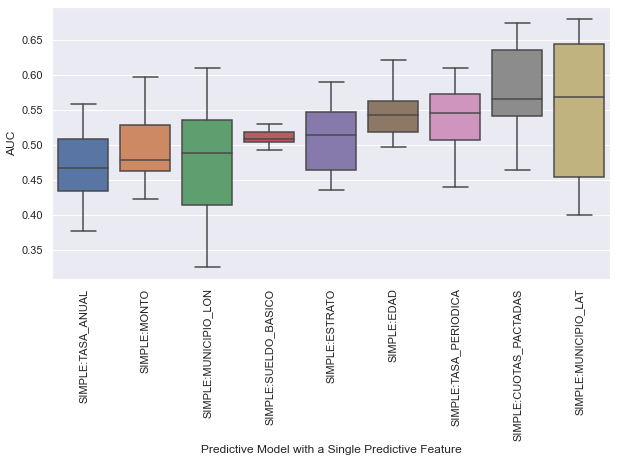

In [54]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

In [62]:
X_full, y_full = Data_numerics.drop(["DEFAULT"], axis=1), Data_numerics.DEFAULT
auc_list = cross_validation_AUC(X_full, y_full)
model_perf["ALL_NUMERICAL"] = auc_list
model_perf

C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which 

SIMPLE:CUOTAS_PACTADAS  SIMPLE:TASA_PERIODICA  SIMPLE:MUNICIPIO_LAT  \
0                0.659615               0.440341              0.609350   
1                0.523219               0.508808              0.490744   
2                0.576671               0.564924              0.442185   
3                0.555234               0.500402              0.679932   
4                0.647604               0.589860              0.417211   
5                0.674333               0.554006              0.632761   
6                0.602853               0.576720              0.528517   
7                0.464394               0.506141              0.400175   
8                0.540224               0.611023              0.648585   
9                0.547057               0.538713              0.648078   

   SIMPLE:MUNICIPIO_LON  SIMPLE:TASA_ANUAL  SIMPLE:MONTO  SIMPLE:EDAD  \
0              0.382299           0.558917      0.422205     0.514692   
1              0.530970           0.376394      0.487295     0.621723   
2              0.537320           0.503911      0.531000     0.523505   
3              0.326045           0.461268      0.470294     0.572531   
4              0.610710           0.518393      0.462268     0.562200   
5              0.394518           0.509407      0.467086     0.563904   
6              0.499695           0.439938      0.597216     0.497899   
7              0.595977           0.394829      0.597911     0.516285   
8              0.478436           0.432804      0.361014     0.533850   
9              0.473801           0.474400      0.523043     0.552833   

   SIMPLE:ESTRATO  SIMPLE:SUELDO_BASICO  ALL_NUMERICAL  
0        0.588484              0.519243       0.502885  
1        0.448546              0.518376       0.625690  
2        0.548230              0.524391       0.535909  
3        0.590001              0.503947       0.552735  
4        0.512481              0.506021       0.527064  
5        0.514296              0.508889       0.528282  
6        0.543357              0.530609       0.508391  
7        0.440448              0.502644       0.548645  
8        0.513666              0.508202       0.532191  
9        0.435868              0.493069       0.527314

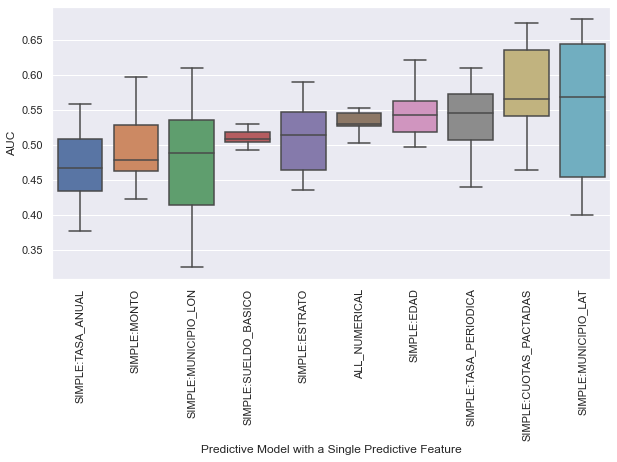

In [63]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

## Incorporating categorical variables

The grade of a loan (i.e. the LC-assigned loan grade feature) has not been used so far. The following is the distribution of the categorical grade feature:

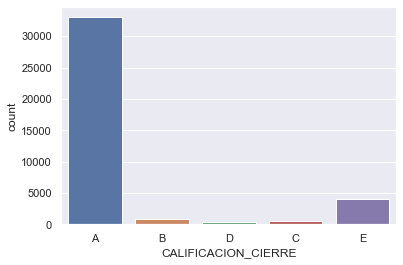

In [64]:
sns.countplot(x='CALIFICACION_CIERRE', data = model_df);

In [65]:
#use a one-hot-encoding approach for incorporating the "grade" categorical variable
grade_categ = pd.get_dummies(model_df['CALIFICACION_CIERRE'], prefix = "grade", drop_first=True)
grade_categ.head()

grade_B  grade_C  grade_D  grade_E
0        0        0        0        0
1        0        0        0        0
2        0        0        0        0
3        0        0        0        0
4        0        0        0        0

In [66]:
X_grade = pd.concat([X_full, grade_categ],axis=1) 
X_grade.head()

CUOTAS_PACTADAS  TASA_PERIODICA  MUNICIPIO_LAT  MUNICIPIO_LON  TASA_ANUAL  \
0             12.0            2.64        4.85430      -73.04003       31.67   
1             36.0            2.94        4.14200      -73.62664       35.29   
2             24.0            2.94        3.98695      -73.75797       35.29   
3             24.0            2.94        3.54625      -73.70687       35.29   
4             12.0            2.94        4.87802      -72.89575       35.29   

      MONTO  EDAD  ESTRATO  SUELDO_BASICO  grade_B  grade_C  grade_D  grade_E  
0  6.301030  51.0      1.0            0.0        0        0        0        0  
1  6.778151  48.0      2.0            0.0        0        0        0        0  
2  6.469822  53.0      2.0            0.0        0        0        0        0  
3  6.462398  50.0      2.0      1400000.0        0        0        0        0  
4  6.000000  73.0      1.0            0.0        0        0        0        0

In [67]:
X_grade = X_grade.dropna()
null_eda = X_grade.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

Empty DataFrame
Columns: [index, Nulos]
Index: []

In [68]:
auc_list = cross_validation_AUC(X_grade, y_full)
model_perf["ALL_NUMERICAL_WITH_GRADE"] = auc_list

C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which 

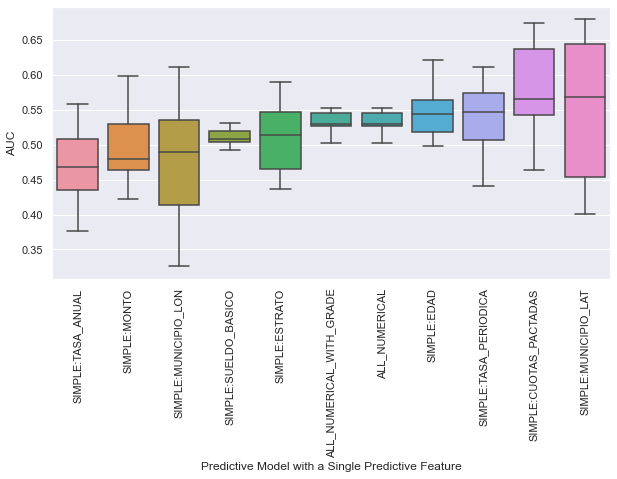

In [69]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

In [70]:
#use a one-hot-encoding approach for incorporating the "TIPO_VIVIENDA" categorical variable
homeownership_categ = pd.get_dummies(model_df['TIPO_VIVIENDA'], prefix = "homeownership", drop_first=True)
homeownership_categ.head()

homeownership_FAMILIAR  homeownership_HIPOTECA  homeownership_OTRA  \
0                       0                       0                   0   
1                       0                       0                   1   
2                       1                       0                   0   
3                       0                       0                   0   
4                       0                       0                   0   

   homeownership_PROPIA  homeownership_SIN_VIVIENDA  
0                     0                           0  
1                     0                           0  
2                     0                           0  
3                     0                           0  
4                     1                           0

In [71]:
X_homeownership = pd.concat([X_grade, homeownership_categ], axis=1) 
X_homeownership.head()

CUOTAS_PACTADAS  TASA_PERIODICA  MUNICIPIO_LAT  MUNICIPIO_LON  TASA_ANUAL  \
0             12.0            2.64        4.85430      -73.04003       31.67   
1             36.0            2.94        4.14200      -73.62664       35.29   
2             24.0            2.94        3.98695      -73.75797       35.29   
3             24.0            2.94        3.54625      -73.70687       35.29   
4             12.0            2.94        4.87802      -72.89575       35.29   

      MONTO  EDAD  ESTRATO  SUELDO_BASICO  grade_B  grade_C  grade_D  grade_E  \
0  6.301030  51.0      1.0            0.0      0.0      0.0      0.0      0.0   
1  6.778151  48.0      2.0            0.0      0.0      0.0      0.0      0.0   
2  6.469822  53.0      2.0            0.0      0.0      0.0      0.0      0.0   
3  6.462398  50.0      2.0      1400000.0      0.0      0.0      0.0      0.0   
4  6.000000  73.0      1.0            0.0      0.0      0.0      0.0      0.0   

   homeownership_FAMILIAR  homeownership_HIPOTECA  homeownership_OTRA  \
0                       0                       0                   0   
1                       0                       0                   1   
2                       1                       0                   0   
3                       0                       0                   0   
4                       0                       0                   0   

   homeownership_PROPIA  homeownership_SIN_VIVIENDA  
0                     0                           0  
1                     0                           0  
2                     0                           0  
3                     0                           0  
4                     1                           0

In [72]:
X_homeownership = X_homeownership.dropna()
null_eda = X_homeownership.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]
X_homeownership.shape

(38502, 18)

In [73]:
auc_list = cross_validation_AUC(X_homeownership, y_full)
model_perf["ALL_NUMERICAL_WITH_HOMEOWNERSHIP"] = auc_list

C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which 

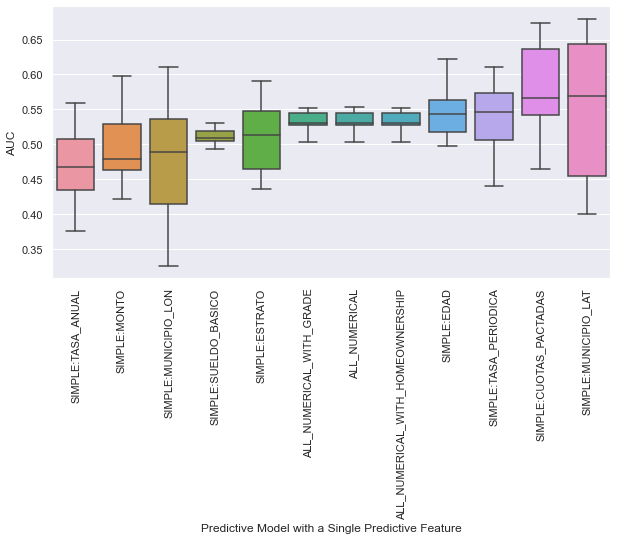

In [74]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

In [75]:
#use a one-hot-encoding approach for incorporating the "TIPO_VIVIENDA" categorical variable
maritalstatus_categ = pd.get_dummies(model_df['ESTADO_CIVIL'], prefix = "marital_status", drop_first=True)
maritalstatus_categ.head()

marital_status_Divorciado  marital_status_Otro  marital_status_Soltero  \
0                          0                    0                       0   
1                          0                    0                       0   
2                          0                    0                       0   
3                          0                    0                       1   
4                          0                    0                       0   

   marital_status_Union libre  marital_status_Viudo  
0                           1                     0  
1                           0                     0  
2                           1                     0  
3                           0                     0  
4                           0                     0

In [76]:
X_maritalstatus = pd.concat([X_homeownership, maritalstatus_categ], axis=1) 
X_maritalstatus.head()

CUOTAS_PACTADAS  TASA_PERIODICA  MUNICIPIO_LAT  MUNICIPIO_LON  TASA_ANUAL  \
0             12.0            2.64        4.85430      -73.04003       31.67   
1             36.0            2.94        4.14200      -73.62664       35.29   
2             24.0            2.94        3.98695      -73.75797       35.29   
3             24.0            2.94        3.54625      -73.70687       35.29   
4             12.0            2.94        4.87802      -72.89575       35.29   

      MONTO  EDAD  ESTRATO  SUELDO_BASICO  grade_B  grade_C  grade_D  grade_E  \
0  6.301030  51.0      1.0            0.0      0.0      0.0      0.0      0.0   
1  6.778151  48.0      2.0            0.0      0.0      0.0      0.0      0.0   
2  6.469822  53.0      2.0            0.0      0.0      0.0      0.0      0.0   
3  6.462398  50.0      2.0      1400000.0      0.0      0.0      0.0      0.0   
4  6.000000  73.0      1.0            0.0      0.0      0.0      0.0      0.0   

   homeownership_FAMILIAR  homeownership_HIPOTECA  homeownership_OTRA  \
0                     0.0                     0.0                 0.0   
1                     0.0                     0.0                 1.0   
2                     1.0                     0.0                 0.0   
3                     0.0                     0.0                 0.0   
4                     0.0                     0.0                 0.0   

   homeownership_PROPIA  homeownership_SIN_VIVIENDA  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   1.0                         0.0   

   marital_status_Divorciado  marital_status_Otro  marital_status_Soltero  \
0                          0                    0                       0   
1                          0                    0                       0   
2                          0                    0                       0   
3                          0                    0                       1   
4                          0                    0                       0   

   marital_status_Union libre  marital_status_Viudo  
0                           1                     0  
1                           0                     0  
2                           1                     0  
3                           0                     0  
4                           0                     0

In [77]:
X_maritalstatus = X_maritalstatus.dropna()
null_eda = X_maritalstatus.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]
X_maritalstatus.shape

(38502, 23)

In [78]:
auc_list = cross_validation_AUC(X_maritalstatus, y_full)
model_perf["ALL_NUMERICAL_WITH_MARITAL_STATUS"] = auc_list

C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which 

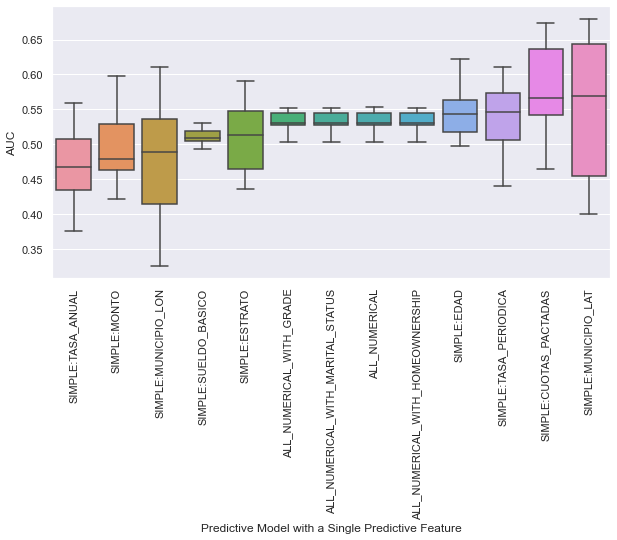

In [79]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

In [80]:
#use a one-hot-encoding approach for incorporating the "OFICIO" categorical variable
job_categ = pd.get_dummies(model_df['OFICIO'], prefix = "job", drop_first=True)
job_categ.head()

job_ AGRICULTOR Y GANADERIA  job_ ALQUILER DE MAQUINARIA  job_ ARRIENDOS   \
0                            0                            0                0   
1                            0                            0                0   
2                            0                            0                0   
3                            0                            0                0   
4                            0                            0                0   

   job_ ARRIENDOS TIENDA AGRICULTURA   job_ CERDOS Y GANADERIA   \
0                                   0                         0   
1                                   0                         0   
2                                   0                         0   
3                                   0                         0   
4                                   0                         0   

   job_ COMERCIANTE  job_ COMERCIANTE DE GANADERIA  \
0                 0                              0   
1                 0                              0   
2                 0                              0   
3                 0                              0   
4                 0                              0   

   job_ CONSTRUCCION DE CASAS  job_ CULTIVO DE MAIZ Y YUCA   \
0                           0                             0   
1                           0                             0   
2                           0                             0   
3                           0                             0   
4                           0                             0   

   job_ CULTIVOS DE GUAYABA  job_ Comercio al por menor de bebi  \
0                         0                                   0   
1                         0                                   0   
2                         0                                   0   
3                         0                                   0   
4                         0                                   0   

   job_ DISEÑO INT. Y OBRA BLANCA   job_ GANADERIA  \
0                                0               0   
1                                0               0   
2                                0               0   
3                                0               0   
4                                0               0   

   job_ GANADERIA Y AGRICULTURA  job_ GUADAÑERO  job_ Ganadería.  \
0                             0               0                0   
1                             0               0                0   
2                             0               0                0   
3                             0               0                0   
4                             0               0                0   

   job_ MANTENIMIENTO COMPUTADORES   job_ MARACUYA   job_ MODISTA  \
0                                 0               0             0   
1                                 0               0             0   
2                                 0               0             0   
3                                 0               0             0   
4                                 0               0             0   

   job_ SERVICIO DE ARRENDAMIENTOS  job_ SIEMBRA DE CULTIVOS DE PAPA   \
0                                0                                  0   
1                                0                                  0   
2                                0                                  0   
3                                0                                  0   
4                                0                                  0   

   job_ TRANSPORTADOR TAXI  job_ VENTA COMIDAS-CAFETERIA  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0   

   job_ VENTA DE COMIDAS Y ARRIENDO  job_ VENTA DE GANADO Y HUE

In [81]:
X_job = pd.concat([X_maritalstatus, job_categ], axis=1) 
X_job.head()

CUOTAS_PACTADAS  TASA_PERIODICA  MUNICIPIO_LAT  MUNICIPIO_LON  TASA_ANUAL  \
0             12.0            2.64        4.85430      -73.04003       31.67   
1             36.0            2.94        4.14200      -73.62664       35.29   
2             24.0            2.94        3.98695      -73.75797       35.29   
3             24.0            2.94        3.54625      -73.70687       35.29   
4             12.0            2.94        4.87802      -72.89575       35.29   

      MONTO  EDAD  ESTRATO  SUELDO_BASICO  grade_B  grade_C  grade_D  grade_E  \
0  6.301030  51.0      1.0            0.0      0.0      0.0      0.0      0.0   
1  6.778151  48.0      2.0            0.0      0.0      0.0      0.0      0.0   
2  6.469822  53.0      2.0            0.0      0.0      0.0      0.0      0.0   
3  6.462398  50.0      2.0      1400000.0      0.0      0.0      0.0      0.0   
4  6.000000  73.0      1.0            0.0      0.0      0.0      0.0      0.0   

   homeownership_FAMILIAR  homeownership_HIPOTECA  homeownership_OTRA  \
0                     0.0                     0.0                 0.0   
1                     0.0                     0.0                 1.0   
2                     1.0                     0.0                 0.0   
3                     0.0                     0.0                 0.0   
4                     0.0                     0.0                 0.0   

   homeownership_PROPIA  homeownership_SIN_VIVIENDA  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   1.0                         0.0   

   marital_status_Divorciado  marital_status_Otro  marital_status_Soltero  \
0                        0.0                  0.0                     0.0   
1                        0.0                  0.0                     0.0   
2                        0.0                  0.0                     0.0   
3                        0.0                  0.0                     1.0   
4                        0.0                  0.0                     0.0   

   marital_status_Union libre  marital_status_Viudo  \
0                         1.0                   0.0   
1                         0.0                   0.0   
2                         1.0                   0.0   
3                         0.0                   0.0   
4                         0.0                   0.0   

   job_ AGRICULTOR Y GANADERIA  job_ ALQUILER DE MAQUINARIA  job_ ARRIENDOS   \
0                            0                            0                0   
1                            0                            0                0   
2                            0                            0                0   
3                            0                            0                0   
4                            0                            0                0   

   job_ ARRIENDOS TIENDA AGRICULTURA   job_ CERDOS Y GANADERIA   \
0                                   0                         0   
1                                   0                         0   
2                                   0                         0   
3                                   0                         0   
4                                   0                         0   

   job_ COMERCIANTE  job_ COMERCIANTE DE GANADERIA  \
0                 0                              0   
1                 0                              0   
2                 0                              0   
3                 0                              0   
4                 0                              0   

   job_ CONSTRUCCION DE CASAS  job_ CULTIVO DE MAIZ Y YUCA   \
0                           0                             0   
1                           0                             0   
2                           0                             0   
3         

In [82]:
X_job = X_job.dropna()
null_eda = X_maritalstatus.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]
X_job.shape

(38502, 4878)

In [ ]:
X_job.keys()
# --> n features

In [ ]:
auc_list = cross_validation_AUC(X_job, y_full)
model_perf["ALL_NUMERICAL_WITH_JOB"] = auc_list

In [ ]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");